#### **Algorithms for Massive Data Analysis**

#### Project Task : Finding similar items

The task is to implement a detector of pairs of similar book reviews.

Here we implemented a structured flow to process similar reviews.  
We worked throught the following steps:
1. Data Loading and Preprocessing  
  a. Removing Null Reviews,  
  b. Genearting a Review_ID to use later on for reduced comparisons  
      (reveiw_id <- combination of book_id, user_id, review/time  
      (Creating a hash for it for memory efficiency)  
  c. Removing Very short reviews (<25 characters lenght),   
  d. Lemmatizing the Text Tokens for root words.  
  e. Removing common StopWords and words like book, read etc.  
2. Hashing the Lemmatized Tokens.  
3. Performing Locally Sensitive MinHashing.  
4. Applying Jaccard Similarity
5. Analysis of Similar Reviews

#### **Kaggle Setup and Library Imports + Data Loading**

##### Setting up Kaggle

In [1]:
from google.colab import files
# API and KEY file
files.upload()                                                                  # Upload the API-KEY File

!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# Dataset
!kaggle datasets download -d mohamedbakhet/amazon-books-reviews                 # Downloading the dataset (zip file)
!unzip amazon-books-reviews.zip                                                 # Unzipping the dataset

ModuleNotFoundError: No module named 'google.colab'

##### Instantiating Spark and Loading *Libraries*

In [2]:
! pip install sparknlp

import sparknlp
spark = sparknlp.start()

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 718.9/718.9 kB 13.7 MB/s eta 0:00:00


In [3]:
# ----------------------------
# Spark & DataFrame Operations
# ----------------------------
from pyspark.sql import SparkSession
from pyspark.sql.functions import (
    col, rand, size, length, expr, lit, split, array, array_except, struct,
    collect_list, regexp_replace, lower, monotonically_increasing_id,
    sha1, concat_ws, xxhash64, udf
)
from pyspark.sql.types import ArrayType, StringType

# --------------------
# Spark MLlib Features
# --------------------
from pyspark.ml.feature import Tokenizer, HashingTF, IDF, MinHashLSH

# ----------------
# NLP - NLTK Setup
# ----------------
import nltk
from nltk.stem import WordNetLemmatizer  # for lemmatization
from nltk.corpus import stopwords
import re                                # regex

# NLTK corpora
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('stopwords')

# --------
# Logging
# --------
import logging

from time import time

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


##### Dataset sampling configuration and loading the **dataset**

In [4]:
# Configuration Parameters

# these are basic default parameters of the main function, however we ran the function for different sample fractions
# and passed the values to function arguments
# directly when calling the functions.

USE_SAMPLE_DATA = True                          # Toggle to use full dataset
SAMPLE_FRACTION = 0.01                          # fraction of dataset to use for analysis if working on a sample
REVIEW_LENGTH = 50                              # Review length used to filter very short reviews
TOKEN_SIZE = 5                                  # Dropping very short lemmatized review (taken to be 5)
FEATURES = 4096                                 # Features in HashingTF
HASHTABLES = 5                                  # HASHTABLES used for LSH
SIM_THRESHOLD = 0.6                             # Similarity threshold for JACCARD Distance
path = "Books_rating.csv"

##### Logging Configuration

In [5]:
import logging
import sys

# Reset logging handlers (important in notebooks or repeated runs)
for handler in logging.root.handlers[:]:
    logging.root.removeHandler(handler)

logging.basicConfig(
    level=logging.INFO,
    format='%(message)s',
    handlers=[logging.StreamHandler(sys.stdout)]
)

#### **Functions Used**

##### Function 1 - Data Loading from the dataset file

In [6]:
# data Loading using Function
def load_sample_preprocess_data(path, USE_SAMPLE_DATA, SAMPLE_FRACTION, seed=42):
    # Loading the dataset
    df = spark.read.csv(path, header=True)                              # path is path of the file

    cleaned_df = df.filter(col("review/text").isNotNull())              # Removing the Nulls from review/text
    cleaned_df.persist()                                                # Caching the cleaned_df

    # print(f"Columns in the dataset are: {cleaned_df.columns}")          # Column Names in the dataset

    if USE_SAMPLE_DATA:
        sampled_df = cleaned_df.sample(withReplacement=False, fraction=SAMPLE_FRACTION, seed=seed)          # Sampling Dataset as per given fraction of sample
        sampled_df.persist()                                                  # caching the sampled_df
    else:
        sampled_df = cleaned_df                                                                  # if no sampling then use full dataset

    #print(f"Number of sampled dataset rows are : {sampled_df.count()}")                         # Count of sampled dataset without nulls

    cleaned_df.unpersist()                                                # UnCaching the cleaned_df (as it is no longer needed)

    # preprocessing to create a review_id by comnbining the three columns and hashing ti to reduce memory space

    sampled_df = sampled_df.withColumn(
        "review_id",
        xxhash64(sha1(concat_ws("_", col("Id"), col("User_id"), col("review/time"))))                      # concatenating with "_" and then hashing (64 bits)
    )

    return sampled_df

##### Function 2 - Data Sampling

In [7]:
def df_selection(sampled_df, REVIEW_LENGTH):

    selected_reviews = sampled_df.select(                              # Selecting only book_id and review/text from the sampled dataset
    col("Id").alias("book_id"),
    col("review/text").alias("review_text"),
    col("review_id")
    )

    # Filtering the reviews with length > 50 characters                             # Rejecting very short reviews from the analysis
    filtered_reviews = selected_reviews.filter(
        length(col("review_text")) > REVIEW_LENGTH                                  # set initially and passed in function
    )

    filtered_reviews = filtered_reviews.dropDuplicates(["review_text"])             # Dropping any duplicates from the dataset (if any in just review_text)
    filtered_reviews = filtered_reviews.dropDuplicates(["review_id"])               # Dropping any duplicates from the dataset (if any in review_id (rare but still))

    # filtered_reviews.persist()                                                      # Caching in memory the required dataset

    # Show the results
    # logging.info(f"Total Sampled Book Reviews for Similarity Search : {filtered_reviews.count()}")             # Overview (Count) of the filtered set

    return filtered_reviews

##### Function 3 - Text Processing and Lemmatization

In [8]:
# function for processing
def text_processing(filtered_reviews, stopwords, TOKEN_SIZE):
  stopword_array = array(*[lit(w) for w in stopwords])  # Convert list to Spark array

  # clean and lemmatize

  lemmatized_reviews_clean = ( filtered_reviews
                              .withColumn("cleaned_text", regexp_replace(col("review_text"), r'[^a-zA-Z\s]', ' '))         # Remove non-alphabetic chars
                              .withColumn("tokens", split(lower(col("cleaned_text")), " "))                          # Convert text to lowercase and split it into tokens
                              .withColumn("tokens", expr("FILTER(tokens, x -> LENGTH(x) > 2 AND x != '')"))                # Filter out tokens that are too short
                              .withColumn("tokens", lemmatize_udf(col("tokens")))                                          # Apply lemmatization
                              .withColumn("tokens", array_except(col("tokens"), stopword_array))                           # Remove stopwords
                              .withColumn("token_size", size(col("tokens")))                                               # Calculate the size of the token array
                              .filter((col("token_size") >= TOKEN_SIZE) & (col("token_size") <= 2000))                     # token count range
                              .persist()
                              )
  return lemmatized_reviews_clean

##### Function 4 - Hashing the lemmatized Text

In [ ]:
##### Hashing the Lemmatized Text to Integer Based Hashes

def hash_tokens(lemmatized_reviews_clean, FEATURES, ):

    hashingTF = HashingTF(inputCol="tokens",
                          outputCol="features",
                          numFeatures=FEATURES)                # FEATURES = 4096 set initially balances performance vs. collision risk

    hashed_reviews = hashingTF.transform(lemmatized_reviews_clean)

    # hashed_reviews.persist()

    return hashed_reviews


In [ ]:
# # Writing from scratch

# # Hashing the Lemmatized text to Integer based hashes

# import hashlib
# import numpy as np
# from collections import Counter

# def simple_hash(token, num_features):
#     """Deterministic hash function to map token to index."""
#     return int(hashlib.md5(token.encode()).hexdigest(), 16) % num_features

# def hash_tokens(lemmatized_reviews_clean, FEATURES=4096):
#     """
#     Args:
#         lemmatized_reviews_clean (List[Dict]): Each dict has a key 'tokens' mapping to a list of tokens.
#         FEATURES (int): Length of the hashed feature vector.

#     Returns:
#         List[np.array]: Each entry is a NumPy array representing a hashed feature vector.
#     """

#     hashed_vectors = []

#     for row in lemmatized_reviews_clean:
#         tokens = row['tokens']
#         vector = np.zeros(FEATURES)
#         counts = Counter(tokens)

#         for token, count in counts.items():
#             idx = simple_hash(token, FEATURES)
#             vector[idx] += count

#         hashed_vectors.append(vector)

#     return hashed_vectors


##### Function 5 - Performing Locally Sensitive Hashing

In [10]:
def local_sensitive_hashing(hashed_reviews,HASHTABLES):
    mh = MinHashLSH(inputCol="features",            # passing in features and converting to hashes
                    outputCol="hashes",
                    numHashTables=HASHTABLES)       # | HASHTABLES=5 set initially     |   The hash table count can be varies as per need (higher leads to more accuracy but resource overhead)

    model = mh.fit(hashed_reviews)                                                  # fit the model

    transformed_reviews = model.transform(hashed_reviews)                           # transform the data (adds "hashes" column)

    #transformed_reviews.persist()                                                   # Caching in memory the required dataset

    return model, transformed_reviews

In [ ]:
from collections import defaultdict
from concurrent.futures import ThreadPoolExecutor
import hashlib

class LSH:
    def __init__(self, num_bands):
        self.b = num_bands
        self.buckets = [defaultdict(list) for _ in range(num_bands)]
        self.r = None
        self.id_counter = 0

    def _hash_band(self, band):
        return hashlib.md5(str(band).encode()).hexdigest()

    def add_signature(self, signature):
        if self.r is None:
            assert len(signature) % self.b == 0, "Signature length must divide evenly into bands"
            self.r = len(signature) // self.b

        bands = [signature[i*self.r:(i+1)*self.r] for i in range(self.b)]

        with ThreadPoolExecutor() as executor:
            hashes = list(executor.map(self._hash_band, bands))

        for i, h in enumerate(hashes):
            self.buckets[i][h].append(self.id_counter)

        self.id_counter += 1

    def get_candidate_pairs(self):
        pairs = set()
        for bucket in self.buckets:
            for ids in bucket.values():
                if len(ids) > 1:
                    for i in range(len(ids)):
                        for j in range(i + 1, len(ids)):
                            pairs.add(tuple(sorted((ids[i], ids[j]))))
        return pairs

##### Function 6 - Jaccard Similarity Application

In [11]:
# Applying Jaccard Similarity

def jaccard_similarity(model, transformed_reviews, SIM_THRESHOLD, SAMPLE_FRACTION): #, show_results=True):

    # Perform similarity join
    similar_pairs = model.approxSimilarityJoin(
        transformed_reviews,
        transformed_reviews,
        threshold=SIM_THRESHOLD,
        distCol="JaccardDistance"
    ).filter(
        col("datasetA.review_id") < col("datasetB.review_id")                 # Avoids duplicate/self pairs using custom review_id we creates initially
    )

    ordered_similar_pairs = similar_pairs.select(
            col("datasetA.book_id").alias("bookA"),
            col("datasetB.book_id").alias("bookB"),
            col("datasetA.review_text").alias("reviewA"),
            col("datasetB.review_text").alias("reviewB"),
            col("JaccardDistance")
        ).orderBy("JaccardDistance")

    # if show_results:
    #     print("Top similar review pairs (sorted by Jaccard distance):")
    #     ordered_similar_pairs.show(truncate=150)
    #     ordered_similar_pairs.persist()

    # similar_pairs.unpersist()

    # print(f"\n We find {ordered_similar_pairs.count()} similar pairs of reviews in the selected (above threshold {1-SIM_THRESHOLD})"
    #       f"(for similarity) in {SAMPLE_FRACTION * 100}% of the dataset.")

    return ordered_similar_pairs

#### **Main Loop for analysis using all defined functions.**

In [13]:
# Defining lemmatizer UDF
lemmatizer = WordNetLemmatizer()

def lemmatize_tokens(tokens):
    return [lemmatizer.lemmatize(token) for token in tokens]

lemmatize_udf = udf(lemmatize_tokens, ArrayType(StringType()))


# Main loop for Different sample fractions
"""
    Here we loop through different sample fractions & process reviews for similarity

    Parameters for different functions used:
    - path                  : file path to dataset
    - sample_fractions      : list of sample sizes we are testing for scalability [e.g. 0.005, 0.01]
    - REVIEW_LENGTH         : minimum length of reviews
    - TOKEN_SIZE            : minimum number of tokens
    - FEATURES              : number of hashing features
    - HASHTABLES            : number of hash tables for LSH
    - SIM_THRESHOLD         : Jaccard similarity threshold (based on distance)

    Output : We return the dictionary for cached_similar_pairs items.
"""

from time import time

def main_loop(path, sample_fractions, REVIEW_LENGTH, TOKEN_SIZE, FEATURES, HASHTABLES, SIM_THRESHOLD, SEED=42):

    cached_similar_pairs = {}                                               # To store persistent DataFrames for all iterations

    for fraction in sample_fractions:
      logging.info(f"\n Running pipeline for SAMPLE_FRACTION = {fraction*100} %.")

      # Step 1: Loading and sampling data
      start = time()
      sampled_df = load_sample_preprocess_data(path, USE_SAMPLE_DATA=True, SAMPLE_FRACTION=fraction, seed=SEED)
      sampled_df.persist()
      logging.info(f" Sampled rows count: {sampled_df.count()}")
      logging.info(f"Time taken for sampling: {(time() - start)/60:.2f} minutes")

      # Step 2: Filter reviews by length
      start = time()
      filtered_reviews = df_selection(sampled_df, REVIEW_LENGTH=REVIEW_LENGTH)
      filtered_reviews.persist()                                              # caching for later use
      #filtered_reviews.show()
      logging.info(f"Total Sampled Book Reviews for Similarity Search : {filtered_reviews.count()}")
      logging.info(f"Time taken for Filtering: {(time() - start)/60:.2f} minutes")

      # Unpersist
      sampled_df.unpersist()

      # Step 3: Text Preprocessing
      start = time()
      standard_stopwords = set(stopwords.words('english'))
      custom_stopwords = {"book", "books", "read", "reading", "word", "paragraph",
                          "magazine", "novel", "page", "chapter"}
      all_stopwords = standard_stopwords.union(custom_stopwords)

      lemmatized_reviews = text_processing(
          filtered_reviews=filtered_reviews,
          stopwords=all_stopwords,
          TOKEN_SIZE=TOKEN_SIZE
      )
      lemmatized_reviews.persist()                                            # caching for later use
      #lemmatized_reviews.show()
      logging.info(f"Time taken for Text Processing: {(time() - start)/60:.2f} minutes")

      # Unpersist
      filtered_reviews.unpersist()

      # Step 4: HashingTF features
      start = time()
      hashed_reviews = hash_tokens(lemmatized_reviews_clean=lemmatized_reviews, FEATURES=FEATURES)
      hashed_reviews.persist()                                                # caching for later use
      print(f"Data frame after Hashing : ")
      hashed_reviews.limit(10).show(truncate=True)
      logging.info(f"Time taken for Hashing: {(time() - start)/60:.2f} minutes")

      # Unpersist
      lemmatized_reviews.unpersist()

      # Step 5: Applying the LSH algorithm
      start = time()
      model, transformed_reviews = local_sensitive_hashing(
          hashed_reviews=hashed_reviews,
          HASHTABLES=HASHTABLES
      )
      transformed_reviews.persist()                                           # caching for later use
      logging.info(f"Data frame after applying LSH : ")
      transformed_reviews.limit(10).show(truncate=True)
      print(f"Time taken for LSH: {(time() - start)/60:.2f} minutes")


      # Step 6: Jaccard similarity for similar pairs
      start = time()
      similar_pairs = jaccard_similarity(
          model=model,
          transformed_reviews=transformed_reviews,
          SIM_THRESHOLD=SIM_THRESHOLD,
          SAMPLE_FRACTION=fraction
      )
      similar_pairs.persist()                                                 # caching for later use
      logging.info(f"Data frame after applying Jaccard Similarity : ")
      logging.info(f"\n We find {similar_pairs.count()} similar pairs of reviews in the selected (above threshold {1-SIM_THRESHOLD})"
      f"(for similarity) in {fraction * 100}% of the dataset.")

      print(f"Time taken for Jaccard similarity: {(time() - start)/60:.2f} minutes")

      # Unpersist
      transformed_reviews.unpersist()

      cached_similar_pairs[fraction] = similar_pairs                          # saved to dictionary, so we can access it separately (not many pairs fo saved to memory later on)

      similar_pairs.show()
      # similar_pairs.unpersist()                                             # To keep the data in dictionary or we save it to memory

      logging.info(f"\n COMPLETED iteration for {fraction*100:.2f}% of data"
                    f"\n{'='*100}")
    return cached_similar_pairs

#### **Code Execution**

In [ ]:
# defining the Sample fractions to check scalability on list of different sample fractions
sample_fractions = [0.005, 0.0075, 0.01, 0.02]

# running the main funtion loop
results = main_loop(path, sample_fractions, REVIEW_LENGTH=25, TOKEN_SIZE=5, FEATURES=4096, HASHTABLES=5, SIM_THRESHOLD=0.6)


 Running pipeline for SAMPLE_FRACTION = 0.5 %.
 Sampled rows count: 15189
Time taken for sampling: 0.02 minutes
Total Sampled Book Reviews for Similarity Search : 15013
Time taken for Filtering: 0.15 minutes
Time taken for Text Processing: 0.01 minutes
Data frame after Hashing : 
+----------+--------------------+--------------------+--------------------+--------------------+----------+--------------------+
|   book_id|         review_text|           review_id|        cleaned_text|              tokens|token_size|            features|
+----------+--------------------+--------------------+--------------------+--------------------+----------+--------------------+
|1561381098|Truly challenging...|-9117893417766134471|Truly challenging...|[truly, challengi...|        27|(4096,[31,164,701...|
|B00021GLQ4|To those who have...|-8858569945214979335|To those who have...|[review, teenlibr...|        84|(4096,[4,8,48,71,...|
|B000Q03CZY|I'm 28 and, sadly...|-8839988376369949289|I m    and  sadly..

##### Saving the similar pairs to csv

In [ ]:
# Loooping throught the dictionary to save the files
for fraction, df in results.items():
    output_path = f"similar_pairs_fraction_{int(fraction*10000)}.parquet"
    df.write.mode("overwrite").parquet(output_path)
    print(f"Saved fraction {fraction} to {output_path}")

Saved fraction 0.005 to similar_pairs_fraction_50.parquet
Saved fraction 0.0075 to similar_pairs_fraction_75.parquet
Saved fraction 0.01 to similar_pairs_fraction_100.parquet
Saved fraction 0.02 to similar_pairs_fraction_200.parquet


#### **Loading the File for 2% Sample Reviews Output**

In [ ]:
df = spark.read.parquet("similar_pairs_fraction_200.parquet")              # loading the saved reviews for 2% of dataset
df.show()
df.printSchema()
df.describe().show()

+----------+----------+--------------------+--------------------+--------------------+
|     bookA|     bookB|             reviewA|             reviewB|     JaccardDistance|
+----------+----------+--------------------+--------------------+--------------------+
|B000NASUVI|B0007HSIP0|McBain created hi...|McBain created hi...|                 0.0|
|B000KW0GVG|B000FG14OK|Fyodor Dostoevksy...|Fyodor Dostoevksy...|                 0.0|
|B000QAANTM|B000NLWCE8|"Ray Bradbury cle...|"_Ray Bradbury cl...|                 0.0|
|B000KAIZX4|B000Q382GK|THE LION THE WITC...|THE LION THE WITC...|0.010752688172043001|
|0754037746|B000H0JB7Q|After I read this...|After I read this...|  0.0714285714285714|
|9997407695|9997407695|"For a book that'...|"For a book that'...| 0.07692307692307687|
|B0006DI4M2|B0006DI4M2|Written nearly ha...|Written over half...| 0.07954545454545459|
|1576463443|0786166363|This book is one ...|This book is one ...| 0.08290155440414504|
|0380801213|0613125355|This was an enjoy...

From the descriptive analysis we see that there is a minimum Jaccard Distance of even 0 which means there are still duplicate reviews (i.e. near duplicates) as we already removed exact duplicates before analysis, and then performed splitting and lemmatization on reviews. It may include reviews with any typos or other minor variations.

#### **Additional Analysis on Similar Pairs**

###### 1. Count of Near vs Exact Matches (>95% match).

In [ ]:
# Near Matches vs Exact Matches

from pyspark.sql.functions import when, count

df.select(
    when(col("JaccardDistance") <= 0.05, "Exact Match")
    .otherwise("Near Match")
    .alias("MatchType")
).groupBy("MatchType").count().show()

+-----------+-----+
|  MatchType|count|
+-----------+-----+
|Exact Match|    4|
| Near Match|  131|
+-----------+-----+



###### 2. Distinct Books in the similar reviews (by bookid)

In [ ]:
# Distinct Book IDs.

# Get distinct book IDs from both sides
unique_books = df.select("bookA").union(df.select("bookB")).distinct()

# Count how many unique books are covered
print(f"Number of unique books covered: {unique_books.count()}")

Number of unique books covered: 199


###### 3. Jaccard Distance Distribution

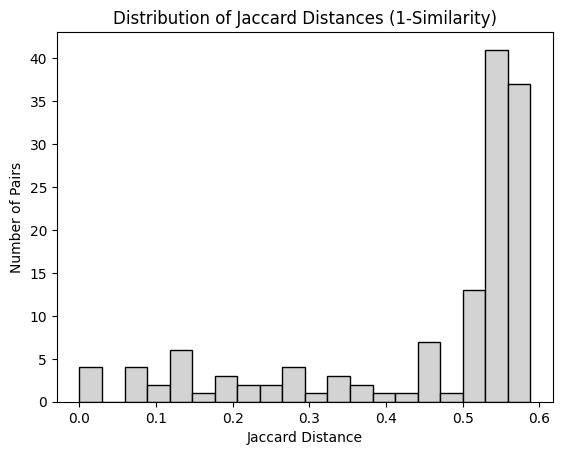

In [ ]:
# Distribution of distance
import matplotlib.pyplot as plt

jaccard_values = df.select("JaccardDistance").toPandas()
plt.hist(jaccard_values["JaccardDistance"], bins=20, color='lightgrey', edgecolor='black')
plt.xlabel("Jaccard Distance")
plt.ylabel("Number of Pairs")
plt.title("Distribution of Jaccard Distances (1-Similarity)")
plt.show()

We see there are many documents with a comparatively less similarity ~40-50% as per Jaccard Similarity, and comparatively less documents with more similarity.

###### 4. Calculating the review lengths

In [ ]:
# review length
df = df.withColumn("lenA", length(col("reviewA"))) \
       .withColumn("lenB", length(col("reviewB")))

df.show()

+----------+----------+--------------------+--------------------+--------------------+----+----+
|     bookA|     bookB|             reviewA|             reviewB|     JaccardDistance|lenA|lenB|
+----------+----------+--------------------+--------------------+--------------------+----+----+
|B000NASUVI|B0007HSIP0|McBain created hi...|McBain created hi...|                 0.0| 197| 196|
|B000KW0GVG|B000FG14OK|Fyodor Dostoevksy...|Fyodor Dostoevksy...|                 0.0| 748| 747|
|B000QAANTM|B000NLWCE8|"Ray Bradbury cle...|"_Ray Bradbury cl...|                 0.0| 490| 491|
|B000KAIZX4|B000Q382GK|THE LION THE WITC...|THE LION THE WITC...|0.010752688172043001|1735|1734|
|0754037746|B000H0JB7Q|After I read this...|After I read this...|  0.0714285714285714| 851| 861|
|9997407695|9997407695|"For a book that'...|"For a book that'...| 0.07692307692307687| 147| 153|
|B0006DI4M2|B0006DI4M2|Written nearly ha...|Written over half...| 0.07954545454545459|2584|2446|
|1576463443|0786166363|This bo

Since we factored in at multiple steps to filter out small reviws, we see we only get similar reviews with comparatively larger length.

###### 5. Different books with identical reviws

In [ ]:
# Identical Reviews for different books ?

df.filter((col("JaccardDistance") <= 0.2) & (col("bookA") != col("bookB"))).show(truncate=150)          # Distance <=0.2 means Similarity > 0.8

print(f"There are {df.filter((col('JaccardDistance') <= 0.2) & (col('bookA') != col('bookB'))).count()} book review pairs with almost identical reviews but different book IDs")

+----------+----------+------------------------------------------------------------------------------------------------------------------------------------------------------+------------------------------------------------------------------------------------------------------------------------------------------------------+--------------------+----+----+
|     bookA|     bookB|                                                                                                                                               reviewA|                                                                                                                                               reviewB|     JaccardDistance|lenA|lenB|
+----------+----------+------------------------------------------------------------------------------------------------------------------------------------------------------+----------------------------------------------------------------------------------------------------------------

There are different book ids with the same reviews which introduces suspicion and also plagiarism in reviews. It also points out that there can be different bookid for same book wich are present in the dataset. And the reveiws just show redundant data (maybe sourced from different platforms), if not plagiarised.  
So we analyzed the pairs where bookids are different but reviews are similar (to filter out similar reviews for same books)  

###### 6. Similar reviews for different books

In [ ]:
# Filter pairs where bookA and bookB are different
similar_across_books = df.filter(col("bookA") != col("bookB"))

similar_across_books.select(
    col("bookA"),
    col("bookB"),
    col("JaccardDistance"),
    col("reviewA"),
    col("reviewB")
).orderBy("JaccardDistance").limit(10).show(truncate=150)

print(f"Count of Review pairs where reviews are similar for different books, is {similar_across_books.count()}.")

+----------+----------+--------------------+------------------------------------------------------------------------------------------------------------------------------------------------------+------------------------------------------------------------------------------------------------------------------------------------------------------+
|     bookA|     bookB|     JaccardDistance|                                                                                                                                               reviewA|                                                                                                                                               reviewB|
+----------+----------+--------------------+------------------------------------------------------------------------------------------------------------------------------------------------------+---------------------------------------------------------------------------------------------------------------

The last review pair looked odd from the starting, so we printed it out to be more clear how the reviews are similar.

In [ ]:
import textwrap

rows = df.filter(col("bookA") == "0613125355").select("reviewA", "reviewB").collect()

for row in rows:
    reviewA = row["reviewA"]
    reviewB = row["reviewB"]

    print("Review A:")
    print("\n".join(textwrap.wrap(reviewA, width=80)))
    print("\n" + "-"*40 + "\n")

    print("Review B:")
    print("\n".join(textwrap.wrap(reviewB, width=80)))
    print("\n" + "="*80 + "\n")

Review A:
I found this book to be an easy read, both funny and romantic. Good job. If you
want to read a book that goes straight to your heart, read Stolen Moments by
Barbara Jeanne Fisher. . .It is a beautiful story of unrequited love. . .for
certain the love story of the nineties. I intended to give the book a quick
read, but I got so caught up in the story that I couldn't put the book down.
From the very beginning, I was fully caught up in the heart-wrenching account of
Julie Hunter's battle with lupus and her growing love for Don Lipton. This love,
in the face of Julie's impending death, makes for a story that covers the range
of human emotions. The touches of humor are great, too, they add some nice
contrast and lighten things a bit when emotions are running high. I've never
read a book more deserving of being published. It has rare depth. Julie's story
will remind your readers that life and love are precious and not to be taken for
granted. It has had an impact on me, and for tha

###### 7. Similar books & reviews Histogram

In [ ]:
# Union bookA and bookB columns to get all appearances | Book Similar Review Frequency

book_counts = df.select(col("bookA").alias("book_id")) \
    .union(df.select(col("bookB").alias("book_id"))) \
    .groupBy("book_id").count().orderBy("count", ascending=False)

book_counts.limit(15).show()

+----------+-----+
|   book_id|count|
+----------+-----+
|B000MUCEDY|    6|
|B000GTH6TI|    6|
|B000KXVMKE|    5|
|B000PE579K|    5|
|1844560333|    4|
|B000867PKY|    4|
|1901768724|    3|
|B000N79P10|    3|
|B000GR7SRK|    3|
|0380801213|    3|
|0613125355|    3|
|086719345X|    3|
|0786222840|    3|
|B000PCD07I|    3|
|B000H9R1Q0|    2|
+----------+-----+



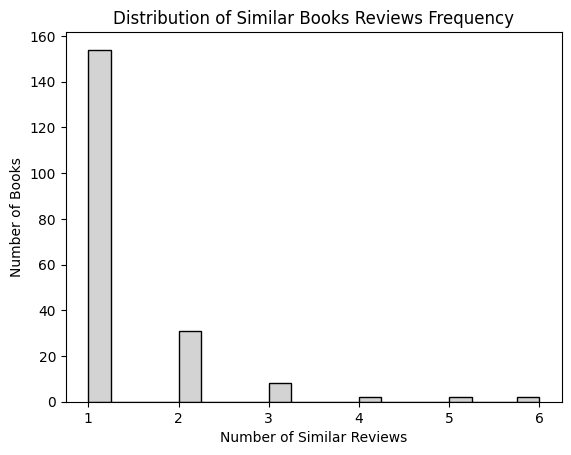

In [ ]:
# Plotting the distribution
book_counts_val = book_counts.select("count").toPandas()
plt.hist(book_counts_val["count"], bins=20, color='lightgrey', edgecolor='black')
plt.xlabel("Number of Similar Reviews")
plt.ylabel("Number of Books")
plt.title("Distribution of Similar Books Reviews Frequency")
plt.show()

###### 8. Wordcloud for Common Words

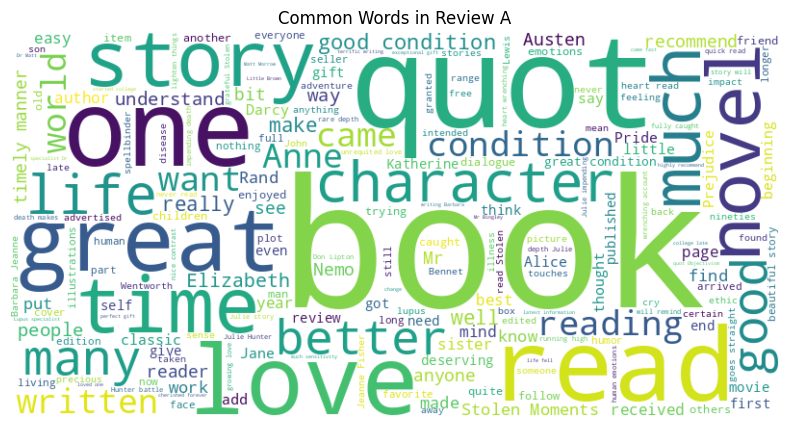

In [ ]:
# Let's also create w wordcloud for these book reviews

from wordcloud import WordCloud

text = " ".join(df.select("reviewA").toPandas()["reviewA"].dropna().values)
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("Common Words in Review A")
plt.show()

#### **End of Analysis**

In [ ]:
# ends the spark session
spark.stop()